In [1]:
import numpy as np

from scipy import constants

#visuals
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
matplotlib.rcParams.update({'font.size': 10})

#Interactive
from ipywidgets.widgets import * 
import ipywidgets as widgets

#take time, for checking if vectorization/program is useful
import time

#Hugo code
import kex_headers
import kex_data
import petlink
import representation
import position
import listmode
import visual

In [2]:
listmode_dataset, listmode_paths = kex_data.listmode()
recons, recon_paths = kex_data.reconstructions()

In [3]:
time_str = "elapsed time"

dictionaries = []
for lm in listmode_dataset:
    time_a = time.time()
    
    dictionaries.append(listmode.get_fov_image_bins(lm))
    
    time_b = time.time()
    print(time_str, time_b-time_a)

elapsed time 6.690100908279419
elapsed time 6.118861198425293
elapsed time 15.330013275146484
elapsed time 14.943021297454834


In [4]:
time_a = time.time()

timetag_indices = []
for lm in listmode_dataset:
    timetag_indices.append(petlink.get_timetag_indices(lm))
    
    time_b = time.time()
    print(time_str, time_b-time_a)

elapsed time 0.270275354385376
elapsed time 0.5305790901184082
elapsed time 1.120002031326294
elapsed time 1.696460247039795


In [5]:
time_a = time.time()

fov_timetags = []
for k, timetags_lm in enumerate(timetag_indices):
    d = dictionaries[k]
    conditions = [d['is_event'], d['is_prompt'], d['is_image_fov']]
    indices = timetags_lm
    for c in conditions:
        indices = listmode.transmit_indices(indices, c)
    fov_timetags.append(indices)
    
    time_b = time.time()
    print(time_str, time_b-time_a)

elapsed time 0.4228663444519043
elapsed time 0.8607280254364014
elapsed time 1.6346592903137207
elapsed time 2.39259672164917


In [6]:
time_a = time.time()

timestep_ms = 100
fov_splits = []
for timetags in fov_timetags:
    splits = petlink.get_timeslice_indices(timetags, timestep_ms)
    #print("number of splits", len(splits))
    fov_splits.append(splits)
    
    time_b = time.time()
    print(time_str, time_b-time_a)

elapsed time 0.0
elapsed time 0.0
elapsed time 0.0
elapsed time 0.0


In [7]:
print(dictionaries[0].keys())

dict_keys(['is_event', 'events', 'tof_lor', 'is_prompt', 'prompts', 'prompt_image_bins', 'is_image_fov', 'fov_image_bins'])


In [8]:
time_a = time.time()

com_traces = []
for k, d in enumerate(dictionaries):
    img_bins = d['fov_image_bins']
    #print(img_bins.shape)
    trace = position.get_center_trace(img_bins, fov_splits[k], masses=None)
    com_traces.append(trace)
    time_b = time.time()
    print(time_str, time_b-time_a)

elapsed time 0.21140098571777344
elapsed time 0.4178495407104492
elapsed time 0.9384584426879883
elapsed time 1.4231939315795898


In [9]:
import importlib
importlib.reload(visual);

In [10]:
phantom_strings = []
for path in listmode_paths:
    phantom_strings.append(path.split('/')[-1].split("PET")[0])
print(phantom_strings)
phantom_strings = phantom_strings[0: : 2]
print(phantom_strings)

['Cylinder', 'Cylinder', 'Kanyl', 'Kanyl']
['Cylinder', 'Kanyl']


In [11]:
recon_com = []
for r in recons:
    recon_com.append(position.center_of_mass(r))

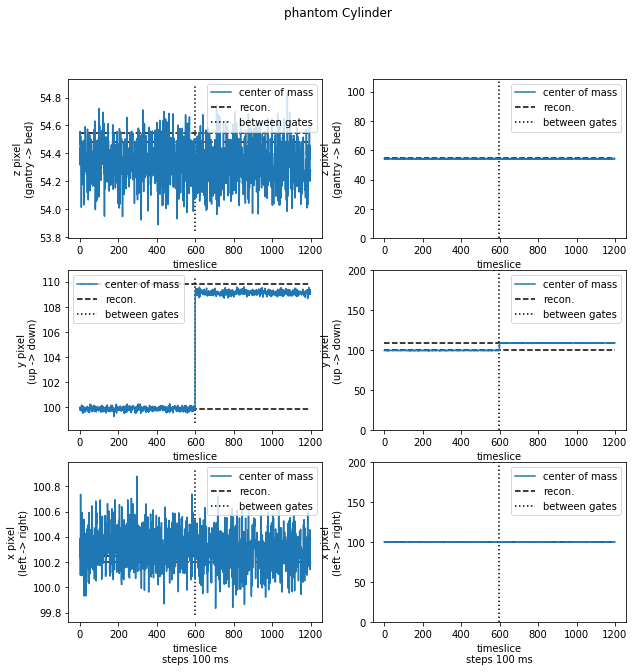

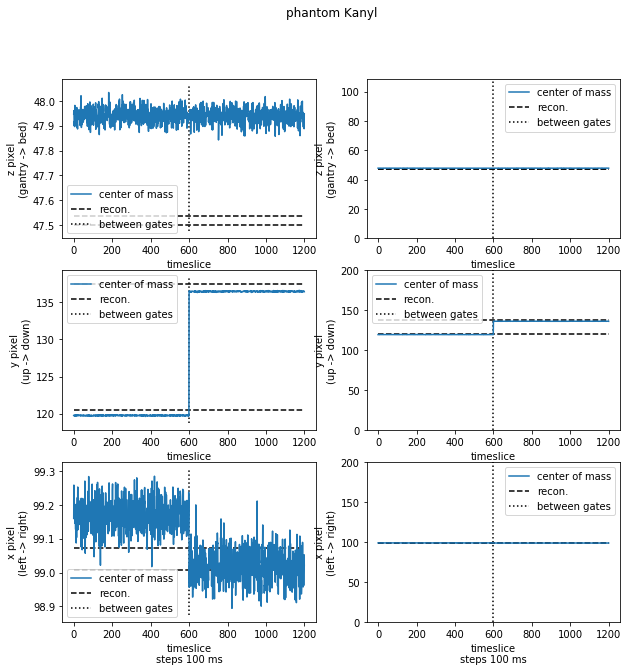

In [12]:
gates_per_phantom = [2,2]
phantom_traces = []
phantom_strings = []
reference_coms = []
gate_times = []
gate_b = 0
for g in gates_per_phantom:
    gate_a = gate_b
    gate_b += g
    phantom_traces.append(np.concatenate(com_traces[gate_a:gate_b],axis=1))
    reference_coms.append(np.stack(recon_com[gate_a:gate_b], axis=1))
    temp = []
    for trace in com_traces[gate_a:gate_b-1]:
        temp.append(len(trace[0])-0.5)
    gate_times.append(temp)
    
    phantom_strings.append(listmode_paths[gate_a].split('/')[-1].split("PET")[0])

for p in range(2):
    plt.figure(figsize=(10,10))
    visual.plot_com_trace(phantom_traces[p], 
                   space_shape=kex_headers.IMAGE_SHAPE, 
                   hlines=reference_coms[p], 
                   vlines=gate_times[p], 
                  dim_str=kex_headers.IMAGE_DIMENSION_TITLES,
                  legends=["center of mass", "recon.", "between gates"],
                  xlabel="timeslice\nsteps " + str(timestep_ms) + " ms",
                  title="phantom " + phantom_strings[p])

In [13]:
importlib.reload(listmode);

In [14]:
time_a = time.time()
trace = listmode.get_com_traces(listmode_dataset[0], timestep=100)
time_b = time.time()
print(time_b-time_a)

7.088034629821777


In [15]:
# now add normalization
normfactors, _ = kex_data.get_norm_factors()

In [16]:
print(dictionaries[0].keys())

dict_keys(['is_event', 'events', 'tof_lor', 'is_prompt', 'prompts', 'prompt_image_bins', 'is_image_fov', 'fov_image_bins'])


In [17]:
masses = []
norms_list = []
randoms_sinograms = []
norm_corr_list = []

for k, d in enumerate(dictionaries):
    time_a = time.time()
    
    #skip tof dimension, which is not normalized
    norm_sino = normfactors[k]
    is_fov_in_events = listmode.expand_indicators(d['is_prompt'], d['is_image_fov'])
    fov_indices = d['tof_lor'][1:, is_fov_in_events]
    
    norms_list.append(d['tof_lor'][1:, fov_indices])
    randoms = d['tof_lor'][1:, d['is_prompt'] == False]
    sinos = []
    events = [randoms, fov_indices]
    for ev in events:
        sinos.append(listmode.get_histogram(ev, kex_headers.LOR_HISTOGRAM_SHAPE,weights=norm_sino[tuple(ev)]))
    r_sino = sinos[0]
    randoms_sinograms.append(r_sino)
    fov_sino = sinos[1]
    nonzero = fov_sino > 0
    r_sino[nonzero] /= fov_sino[nonzero]

    corr_sino = np.maximum(norm_sino - r_sino, 0)
    #print(fov_indices.shape)
    #print(corr_sino.shape)
    #print(r_sino.shape)
    #print(nonzero.shape)
    corr_list = corr_sino[tuple(fov_indices)]
    norm_corr_list.append(corr_list)
    time_b = time.time()
    print(time_b-time_a)

6.806758403778076
7.026234865188599
11.309707641601562
10.652537107467651


In [18]:
print(normfactors[0].shape)

(621, 168, 400)


In [19]:
data_number = 3
test = position.get_center_trace(dictionaries[data_number]['fov_image_bins'], 
                                 split_indices=fov_splits[data_number], 
                                 masses=norm_corr_list[data_number])

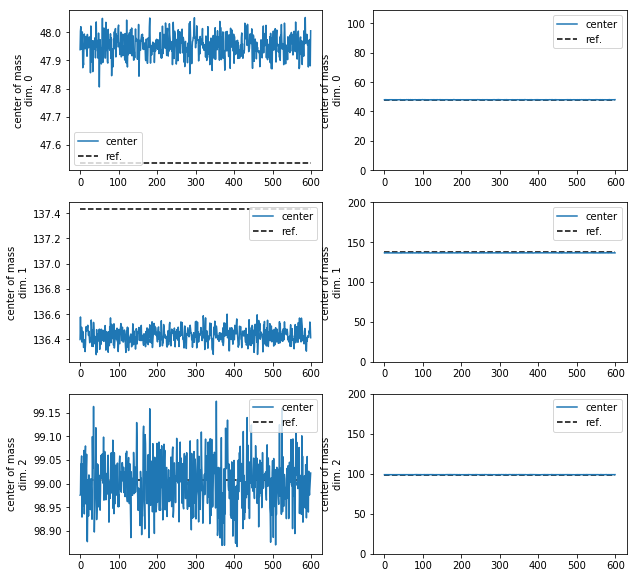

In [20]:
plt.figure(figsize=(10,10))
visual.plot_com_trace(test, space_shape= kex_headers.IMAGE_SHAPE, hlines = recon_com[data_number])

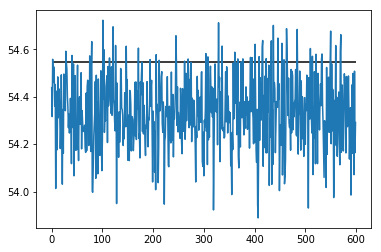

In [21]:
plt.plot(com_traces[0][0])
plt.hlines(recon_com[0][0], 0, 600);

In [22]:
A = [1,2]
print(A[(True,False)])

TypeError: list indices must be integers or slices, not tuple

In [ ]:
A = np.arange(15)
print(np.empty((2,) + A.shape, dtype=int))

In [ ]:
print([True,False].index(False))

In [91]:
importlib.reload(listmode);

In [47]:
time_a = time.time()
masses = listmode.get_norms(d['tof_lor'], d['is_prompt'], normfactors[-1])
tim_b = time.time()

In [93]:
time_a = time.time()
trace = listmode.get_com_traces(listmode_dataset[0], 100, None)
time_b = time.time()
print(time_b-time_a)

7.118706703186035


In [94]:
time_a = time.time()
trace2 = listmode.get_com_traces(listmode_dataset[0], 100, normfactors[0])
time_b = time.time()
print(time_b-time_a)

13.622883796691895


In [79]:
14688186 / 2116091

6.941188257026754

In [76]:
print(np.prod(kex_headers.LOR_HISTOGRAM_SHAPE))

41731200


In [70]:
d = dictionaries[0]
print(len(d['tof_lor'][0]))
print(len(d['prompts']))
print(len(d['fov_image_bins'][0]))

16804277
14688186
14611223


In [71]:
2116091 / 14688186

0.1440675519768064

In [44]:
print(trace.dtype)

float64


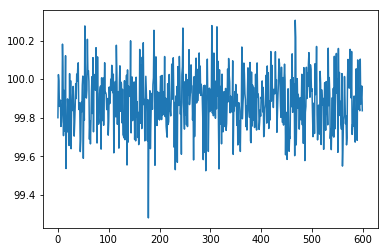

In [42]:
plt.plot(trace[1])


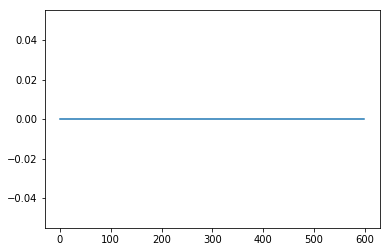

In [43]:
plt.plot(trace2[1]-trace[1])

In [41]:
A = [False, True, False]
B = [False, True]
C = listmode.expand_indicators(A,B)
print(C)

[False  True False]


In [55]:
A = np.array([True,True,False,True])
B = np.array([True, False, False, True])
C = listmode.convert_condition(B,A)
print(C)
print(A[A])

[ True False  True]
[ True  True  True]


In [57]:
a_of_b = [True, False, True]
b_of_c = [True, True, False, True]
a_of_c = listmode.is_a_in_c(a_of_b, b_of_c)
print(a_of_c)

[ True False False  True]


In [63]:
fov_count = np.sum(d['is_image_fov'])
prompt_count = np.sum(d['is_prompt'])
print(fov_count)
print(prompt_count)

36049353
36099939
